<a href="https://colab.research.google.com/github/Krushna-sahoo/Fake_new_Detection_Bert/blob/main/Fake_news_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install pycaret

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.1/486.1 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 52.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 24.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.0/258.0 kB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.7/80.7 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 48.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB

In [3]:
import numpy as np
import pandas as pd
import pycaret
import transformers
from transformers import AutoModel, BertTokenizerFast
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch
import torch.nn as nn
# specify GPU
device = torch.device("cuda")

In [4]:
true_df=pd.read_csv("/content/drive/MyDrive/True.csv")
fake_df=pd.read_csv("/content/drive/MyDrive/Fake.csv")

#creating a target variable with true and fake value
true_df['Target'] = ['True']*len(true_df)
fake_df['Target'] = ['Fake']*len(fake_df)

#Now joining both the news
df=pd.concat([true_df,fake_df],ignore_index=True)

df=df.sample(frac=1).reset_index(drop=True)

print(df.shape)
df.head()

(44898, 5)


,title,text,subject,date,Target
0,Japan to acquire air-launched missiles able to...,TOKYO (Reuters) - Japan is to acquire medium-r...,worldnews,"December 8, 2017",True
1,WOW! BERKELEY MAYOR Who Allegedly Told Police ...,Americans were stunned when they were told the...,politics,"Apr 21, 2017",Fake
2,Iraq cabinet plans to cut Kurdistan share in 2...,"BAGHDAD/ERBIL, Iraq (Reuters) - Iraq s cabinet...",worldnews,"November 6, 2017",True
3,ALARMING: NSA Refuses to Release Clinton-Lynch...,If Clinton and Lynch just talked about grandki...,Government News,"Jun 3, 2017",Fake
4,"Muslims Raise $20,000 In THREE HOURS To Fix V...",Ever since Donald Trump was elected by a minor...,News,"February 21, 2017",Fake


In [5]:
# Creatinga a new column and making the fake news as 1
df['label']=pd.get_dummies(df.Target)['Fake']
df.head()

,title,text,subject,date,Target,label
0,Japan to acquire air-launched missiles able to...,TOKYO (Reuters) - Japan is to acquire medium-r...,worldnews,"December 8, 2017",True,False
1,WOW! BERKELEY MAYOR Who Allegedly Told Police ...,Americans were stunned when they were told the...,politics,"Apr 21, 2017",Fake,True
2,Iraq cabinet plans to cut Kurdistan share in 2...,"BAGHDAD/ERBIL, Iraq (Reuters) - Iraq s cabinet...",worldnews,"November 6, 2017",True,False
3,ALARMING: NSA Refuses to Release Clinton-Lynch...,If Clinton and Lynch just talked about grandki...,Government News,"Jun 3, 2017",Fake,True
4,"Muslims Raise $20,000 In THREE HOURS To Fix V...",Ever since Donald Trump was elected by a minor...,News,"February 21, 2017",Fake,True


In [6]:
# Now train-validation-test spilt into 70:15:15
#Train-temp split
train_text, temp_text,train_labels,temp_labels=train_test_split(df['title'],df['label'],random_state=2000,test_size=0.3,stratify=df['Target'])

#Validation test split
val_text,test_text,val_labels,test_labels=train_test_split(temp_text,temp_labels,random_state=2000,test_size=0.5,stratify=temp_labels)

In [7]:
#Now loading the bert base model via hugging face
bert= AutoModel.from_pretrained('bert-base-uncased')
tokenizer=BertTokenizerFast.from_pretrained('bert-base-uncased')

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Text(0, 0.5, 'Number of texts')

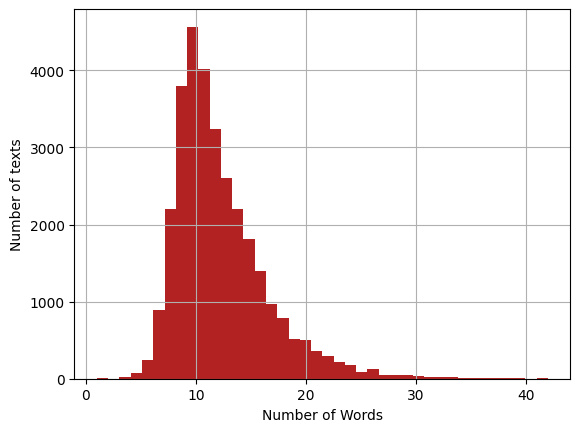

In [8]:
# Plot histogram of the number of words in train data 'title'
seq_len = [len(title.split()) for title in train_text]

pd.Series(seq_len).hist(bins = 40,color='firebrick')
plt.xlabel('Number of Words')
plt.ylabel('Number of texts')

In [9]:
# BERT Tokeizer Functionality
sample_data = ["Build fake news model.","Using bert."]                            # sample data
tokenized_sample_data = tokenizer.batch_encode_plus(sample_data,padding=True)     # encode text
print(tokenized_sample_data)


{'input_ids': [[101, 3857, 8275, 2739, 2944, 1012, 102], [101, 2478, 14324, 1012, 102, 0, 0]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 0, 0]]}


In [10]:
# Majority of titles above have word length under 15. So, we set max title length as 15
MAX_LENGTH = 15
# Tokenize and encode sequences in the train set
tokens_train = tokenizer.batch_encode_plus(train_text.tolist(),max_length = MAX_LENGTH,pad_to_max_length=True,truncation=True)

#Tokenize and encode sequence in the validation set
tokens_val= tokenizer.batch_encode_plus(val_text.tolist(),max_length=MAX_LENGTH,pad_to_max_length=True,truncation=True)

#Tokenize and encode sequence in the test set
tokens_test= tokenizer.batch_encode_plus(test_text.tolist(),max_length=MAX_LENGTH,pad_to_max_length=True,truncation=True)

In [11]:
#Converting list to tensors
train_seq=torch.tensor(tokens_train['input_ids'])
train_mask=torch.tensor(tokens_train['attention_mask'])
train_y=torch.tensor(train_labels.tolist())

val_seq=torch.tensor(tokens_val['input_ids'])
val_mask=torch.tensor(tokens_val['attention_mask'])
val_y=torch.tensor(val_labels.tolist())

test_seq=torch.tensor(tokens_test['input_ids'])
test_mask=torch.tensor(tokens_test['attention_mask'])
test_y=torch.tensor(test_labels.tolist())

In [12]:
#Data loader Structure
from torch.utils.data  import TensorDataset, DataLoader, RandomSampler, SequentialSampler
batch_size=32

train_data=TensorDataset(train_seq,train_mask,train_y)                            #wrap tensors
train_sampler=RandomSampler(train_data)                                           #Sampler for sampling the data during training
train_loader=DataLoader(train_data, sampler=train_sampler, batch_size=batch_size) #DataLoader for train set

val_data=TensorDataset(val_seq,val_mask,val_y)                              #wrap tensors
val_sampler=RandomSampler(val_data)                                         #Sampler for sampling the data during training
val_loader=DataLoader(val_data, sampler=val_sampler, batch_size=batch_size) #DataLoader for validation set

In [13]:
# Freezing the parameters and defining trainable BERT structure
for param in bert.parameters():
    param.requires_grad = False    # false here means gradient need not be computed

In [14]:
class bert_arc(nn.Module):
  def __init__(self, bert):
    super(bert_arc, self).__init__()
    self.bert=bert
    self.dropout=nn.Dropout(0.1)        #Dropout layer
    self.relu=nn.ReLU()                 #relu activation function
    self.f1=nn.Linear(768,512)          #Dense layer
    self.f2=nn.Linear(512,2)            #Dense layer(otput layer)
    self.softmax=nn.LogSoftmax(dim=1)   #Softmax activation

  def forward(self, sent_id, mask):
    cls_hs = self.bert(sent_id, attention_mask=mask)['pooler_output']  #pass the inputs to the model
    x=self.f1(cls_hs)               #Dense layer
    x=self.relu(x)                  #relu activation function
    x=self.dropout(x)               #Dropout layer
    x=self.f2(x)                    #Output layer
    x=self.softmax(x)               #Softmax activation function
    return x

model=bert_arc(bert)

#Defining the hyperparameters
#defining the optimizers

from transformers import AdamW
optimizer=AdamW(model.parameters(), lr= 1e-5) #lr is the learning rate of the adam optimizer

# Define the loss function
cross_entropy  = nn.NLLLoss()

# Number of training epochs
epochs = 2

In [15]:
#Model training and Evaluation

def train():
    model.train()
    total_loss, total_accuracy = 0, 0

    for step, batch in enumerate(train_loader):  # Iterate over batches
        if step % 50 == 0 and not step == 0:  # Print progress update after every 50 batches
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_loader)))
        batch = [r for r in batch]  # Push the batch to GPU
        sent_id, mask, labels = batch
        model.zero_grad()  # Clear previously calculated gradients
        preds = model(sent_id, mask)  # Get model predictions for the current batch
        labels = labels.type(torch.LongTensor)  # Convert labels to LongTensor
        loss = cross_entropy(preds, labels)  # Compute loss between actual and predicted values
        total_loss = total_loss + loss.item()  # Add to the total loss
        loss.backward()  # Backward pass to calculate the gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Clip gradients to 1.0 to prevent exploding gradient problem
        optimizer.step()  # Update parameters
        preds = preds.detach().cpu().numpy()  # Move model predictions from GPU to CPU

    avg_loss = total_loss / len(train_loader)  # Compute training loss of the epoch
    # Reshape predictions in the form of (# samples, # classes)
    return avg_loss  # Return the loss

def evaluate():
    print("\nEvaluating...")
    model.eval()                                                    # Deactivate dropout layers
    total_loss, total_accuracy = 0, 0
    for step, batch in enumerate(val_loader):                       # Iterate over batches
        if step % 50 == 0 and not step == 0:                        # Print progress update every 50 batches
                                                                    # Calculate elapsed time in minutes.
                                                                    # Elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_loader)))
                                                                    # Report progress
        batch = [t for t in batch]                                  # Push the batch to GPU
        sent_id, mask, labels = batch
        with torch.no_grad():                                       # Deactivate autograd
            preds = model(sent_id, mask)                            # Get model predictions
            loss = cross_entropy(preds, labels.type(torch.LongTensor).squeeze())                     # Compute the validation loss between actual and predicted values
            total_loss = total_loss + loss.item()
            preds = preds.detach().cpu().numpy()
    avg_loss = total_loss / len(val_loader)                         # Compute the validation loss of the epoch
    return avg_loss                                                 # Return the loss

In [16]:
#Model Training and Prediction
best_valid_loss=float('inf')
train_losses=[]
valid_losses=[]

for epoch in range(epochs):
  print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
  train_loss = train()                       # train model
  valid_loss = evaluate()                    # evaluate model
  if valid_loss < best_valid_loss:           # save the best model
      best_valid_loss = valid_loss
      torch.save(model.state_dict(), 'c2_new_model_weights.pt')
  train_losses.append(train_loss)            # append training and validation loss
  valid_losses.append(valid_loss)

  print(f'\nTraining  Loss:{train_loss:.3f}')
  print(f'Validation  Loss:{valid_loss:.3f}')


 Epoch 1 / 2
  Batch    50  of    983.
  Batch   100  of    983.
  Batch   150  of    983.
  Batch   200  of    983.
  Batch   250  of    983.
  Batch   300  of    983.
  Batch   350  of    983.
  Batch   400  of    983.
  Batch   450  of    983.
  Batch   500  of    983.
  Batch   550  of    983.
  Batch   600  of    983.
  Batch   650  of    983.
  Batch   700  of    983.
  Batch   750  of    983.
  Batch   800  of    983.
  Batch   850  of    983.
  Batch   900  of    983.
  Batch   950  of    983.

Evaluating...
  Batch    50  of    211.
  Batch   100  of    211.
  Batch   150  of    211.
  Batch   200  of    211.

Training  Loss:0.566
Validation  Loss:0.481

 Epoch 2 / 2
  Batch    50  of    983.
  Batch   100  of    983.
  Batch   150  of    983.
  Batch   200  of    983.
  Batch   250  of    983.
  Batch   300  of    983.
  Batch   350  of    983.
  Batch   400  of    983.
  Batch   450  of    983.
  Batch   500  of    983.
  Batch   550  of    983.
  Batch   600  of    983.
  

In [17]:
#Loading the model
path='c2_new_model_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [18]:
with torch.no_grad():
  preds=model(test_seq, test_mask)
  preds=preds.detach().cpu().numpy()
preds=np.argmax(preds,axis=1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

       False       0.76      0.91      0.83      3212
        True       0.90      0.74      0.81      3523

    accuracy                           0.82      6735
   macro avg       0.83      0.82      0.82      6735
weighted avg       0.83      0.82      0.82      6735



In [20]:
# testing on unseen data
unseen_news_text = ["Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing",     # Fake
                    "U.S. lawmakers question businessman at 2016 Trump Tower meeting: sources",           # True
                    "Trump administration issues new rules on U.S. visa waivers"                          # True
                    ]

# tokenize and encode sequences in the test set
MAX_LENGHT = 15
tokens_unseen = tokenizer.batch_encode_plus(
    unseen_news_text,
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)

unseen_seq = torch.tensor(tokens_unseen['input_ids'])
unseen_mask = torch.tensor(tokens_unseen['attention_mask'])

with torch.no_grad():
  preds = model(unseen_seq, unseen_mask)
  preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis = 1)
preds

array([1, 0, 0])

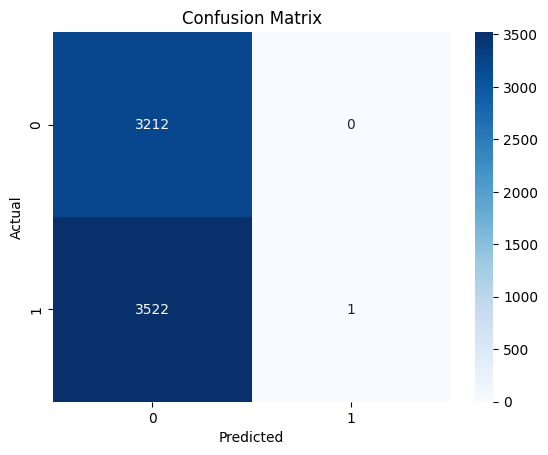

In [26]:

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

if len(test_y) != len(preds):
    if len(test_y) > len(preds):
        preds = np.pad(preds, (0, len(test_y) - len(preds)), 'constant')
    else:
        test_y = np.pad(test_y, (0, len(preds) - len(test_y)), 'constant')

cm = confusion_matrix(test_y, preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
